In [1]:
%matplotlib inline
from datetime import timedelta, datetime
from env import user, password, host
from math import sqrt 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import Holt, ExponentialSmoothing
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import statsmodels.api as sm
import warnings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-whitegrid')
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('saas.csv')

Exercises
The end result of this exercise should be a Jupyter notebook named model.

Using saas.csv or log data from API usage or store_item_sales

Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
Simple Average
Moving Average
Holt's Linear Trend Model
Based on previous year/month/etc., this is up to you.

In [3]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [5]:
df.shape

(790458, 5)

In [6]:
df=df.rename(columns={'Month_Invoiced':'invoice_date', 'Customer_Id':'customer_id', 'Invoice_Id':'invoice_id', 'Subscription_Type':'subscription_type','Amount':'amount'})

In [7]:
# Reassign the sale_date column to be a datetime type
df.invoice_date = pd.to_datetime(df.invoice_date)

# Set the index as that date and then sort index (by the date)
df = df.set_index("invoice_date").sort_index()


In [8]:
df.head()

,customer_id,invoice_id,subscription_type,amount
invoice_date,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [9]:
df_resampled = df.resample('M')[['amount']].sum()
df_resampled.head()

,amount
invoice_date,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [10]:
df_resampled.shape

(48, 1)

In [11]:
# set train size to be 50% of total 
train_size = int(round(df_resampled.shape[0] * 0.5))
train_size

24

In [12]:
# set train size to be 30% of total 
validate_size = int(round(df_resampled.shape[0] * 0.3))
validate_size

14

In [13]:
# set test size to be number of rows remaining. 
test_size = int(round(df_resampled.shape[0] * 0.2))
test_size

10

In [14]:
len(df_resampled) == train_size + validate_size + test_size

True

In [15]:
validate_end_index = train_size + validate_size
validate_end_index

38

In [16]:
train = df_resampled[:train_size]

In [17]:
validate = df_resampled[train_size:validate_end_index]

In [18]:
test = df_resampled[validate_end_index:]

In [19]:
train.head()

,amount
invoice_date,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [20]:
train.shape

(24, 1)

In [21]:
train.tail()

,amount
invoice_date,
2015-08-31,50495.0
2015-09-30,50985.0
2015-10-31,51445.0
2015-11-30,51260.0
2015-12-31,51505.0


In [22]:
test.shape

(10, 1)

In [23]:
test.head()

,amount
invoice_date,
2017-03-31,53480.0
2017-04-30,53350.0
2017-05-31,53340.0
2017-06-30,53405.0
2017-07-31,53680.0


Forecast, plot and evaluate using each of the 4 parametric based methods we discussed: Simple Average Moving Average Holt's Linear Trend Model Based on previous year/month/etc., this is up to you.



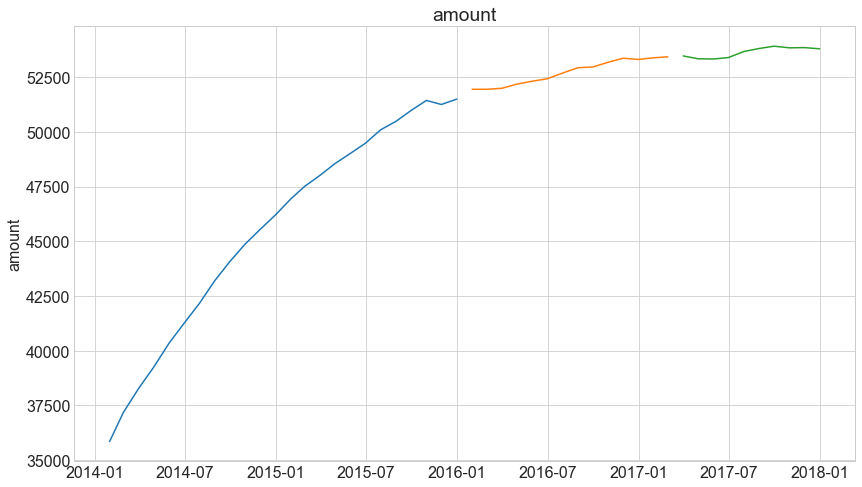

In [24]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow.

evaluate() will compute the Mean Squared Error and the Root Mean Squared Error to evaluate.

In [25]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance. 

In [26]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

Write append_eval_df(model_type) to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our eval_df data frame object. Which we will create an empty eval_df dataframe object to start.

In [27]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [28]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

Forecast, plot and evaluate using each of the 4 parametric based methods we discussed: Simple Average Moving Average Holt's Linear Trend Model Based on previous year/month/etc., this is up to you.

In [29]:
train['amount'][-1:][0]

51505.0

In [30]:
# take the last item of sales total and assign to variable
last_amount = train['amount'][-1:][0]
last_amount

51505.0

In [31]:
yhat_df = pd.DataFrame(
    {'amount': [last_amount]},
    index=validate.index)

yhat_df.head()

,amount
invoice_date,
2016-01-31,51505.0
2016-02-29,51505.0
2016-03-31,51505.0
2016-04-30,51505.0
2016-05-31,51505.0


In [32]:
yhat_df.describe()

,amount
count,14.0
mean,51505.0
std,0.0
min,51505.0
25%,51505.0
50%,51505.0
75%,51505.0
max,51505.0


amount -- RMSE: 1343


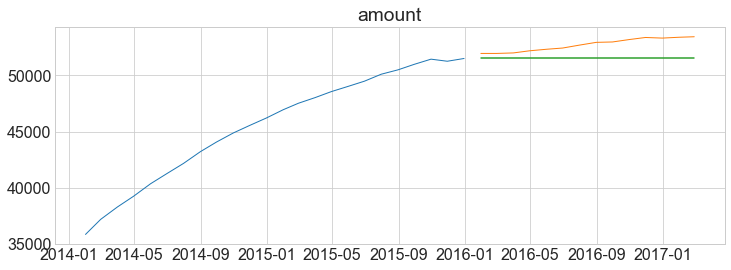

In [33]:
plot_and_eval('amount')

amount -- RMSE: 1343


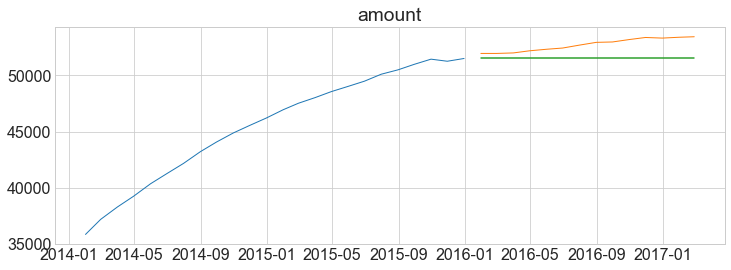

In [34]:
for col in train.columns:
    plot_and_eval(col)

In [35]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0


In [36]:
# compute simple average
avg_amount = round(train['amount'].mean(), 2)
avg_amount

45568.54

Apply predictions to our observations

In [37]:
def make_predictions(amount=None):
    yhat_df = pd.DataFrame({'amount': [amount]},
                          index=validate.index)
    return yhat_df

In [38]:
yhat_df = make_predictions(avg_amount)

In [39]:
yhat_df.head()

,amount
invoice_date,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54
2016-04-30,45568.54
2016-05-31,45568.54


In [40]:
yhat_df.describe()

,amount
count,1.400000e+01
mean,4.556854e+04
std,7.550618e-12
min,4.556854e+04
25%,4.556854e+04
50%,4.556854e+04
75%,4.556854e+04
max,4.556854e+04


amount -- RMSE: 7181


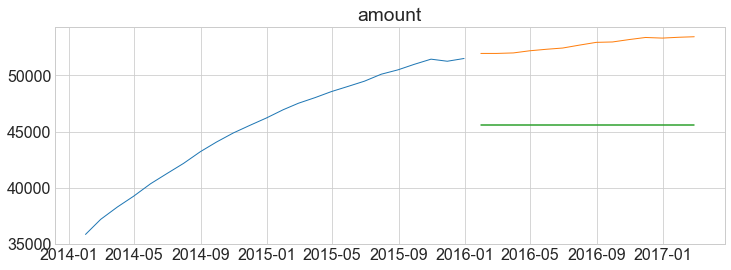

In [41]:
for col in train.columns:
    plot_and_eval(col)

Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [42]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_average,amount,7181.0


Moving Average
In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value.

In [43]:
# demonstrate that the mean of the first 3 months 

print(train['amount'].rolling(3).mean())

invoice_date
2014-01-31             NaN
2014-02-28             NaN
2014-03-31    37111.666667
2014-04-30    38246.666667
2014-05-31    39301.666667
2014-06-30    40288.333333
2014-07-31    41260.000000
2014-08-31    42211.666667
2014-09-30    43151.666667
2014-10-31    44055.000000
2014-11-30    44833.333333
2014-12-31    45545.000000
2015-01-31    46233.333333
2015-02-28    46891.666667
2015-03-31    47496.666667
2015-04-30    48035.000000
2015-05-31    48536.666667
2015-06-30    49023.333333
2015-07-31    49538.333333
2015-08-31    50028.333333
2015-09-30    50528.333333
2015-10-31    50975.000000
2015-11-30    51230.000000
2015-12-31    51403.333333
Freq: M, Name: amount, dtype: float64


In [44]:
period = 3 

# take 3 week rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
rolling_amount = round(train['amount'].rolling(period).mean()[-1], 2)
print(rolling_amount)

51403.33


In [45]:
yhat_df = make_predictions(rolling_amount)
yhat_df.head()

,amount
invoice_date,
2016-01-31,51403.33
2016-02-29,51403.33
2016-03-31,51403.33
2016-04-30,51403.33
2016-05-31,51403.33


Plot Actual vs. Predicted Values

Now, let's plot and evaluate the performance of our time series model using Moving Average

amount -- RMSE: 1436


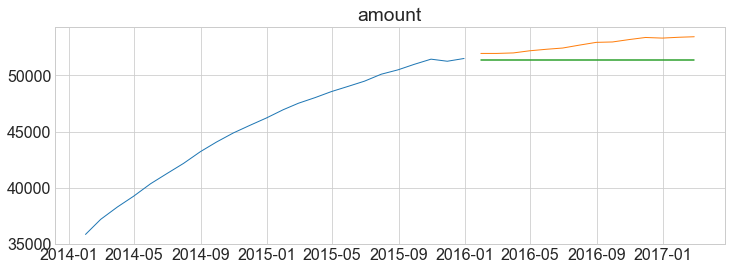

In [46]:
for col in train.columns:
    plot_and_eval(col)

Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [47]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '3 month_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_average,amount,7181.0
2,3 month_moving_avg,amount,1436.0


In [48]:
periods = [1,2,3,4,10]

for p in periods: 
    rolling_amount = round(train['amount'].rolling(p).mean()[-1], 2)
    
    yhat_df = make_predictions(rolling_amount)
    model_type = str(p) + '_month_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [49]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_average,amount,7181.0
2,3 month_moving_avg,amount,1436.0
3,1_month_moving_avg,amount,1343.0
4,2_month_moving_avg,amount,1455.0
5,3_month_moving_avg,amount,1436.0
6,4_month_moving_avg,amount,1533.0
7,10_month_moving_avg,amount,2696.0


In [50]:
min_items_rmse = eval_df[eval_df.target_var == 'amount']['rmse'].min()

In [51]:
min_items_rmse

1343.0

In [52]:
eval_df[eval_df.rmse == min_items_rmse]

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
3,1_month_moving_avg,amount,1343.0


Holt's Linear Trend
Exponential smoothing applied to both the average and the trend (slope).

𝛼  / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.
𝛽  / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values.
Seasonal Decomposition

First, let's take a look at the seasonal decomposition for each target.

In [53]:
import statsmodels.api as sm

In [54]:
train.shape

(24, 1)

amount 



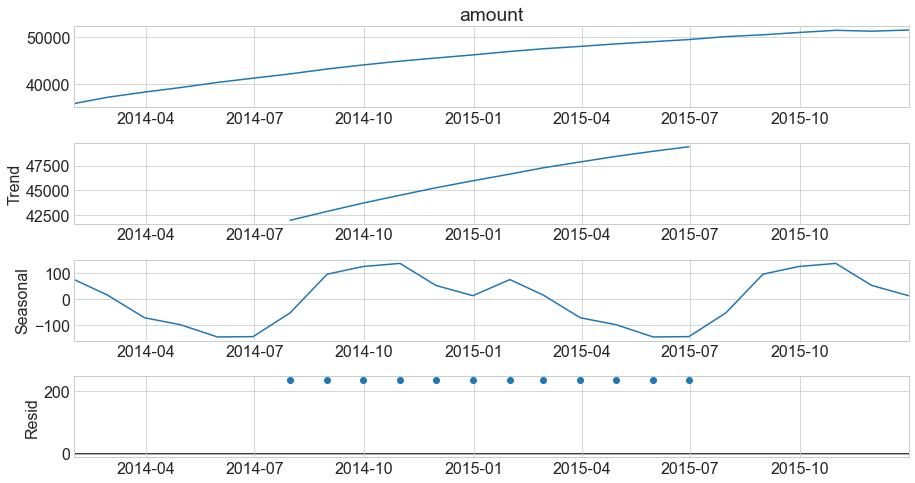

In [55]:
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
plt.show()

Basic Holt's Linear Trend
Make Predictions

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions.

Holt:

exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
damped  𝜙  = True/False: with Holt, forecasts will increase or decrease indefinitely into the future. To avoid this, use the Damped trend method which has a damping parameter 0< ϕ <1.
fit:

smoothing_level ( 𝛼 ): value between (0,1)
Closer to 0, the level doesn't change with each new observation
Closer to 1, the level reacts strongly with each new observation
smoothing_slope ( 𝛽 ): value between (0,1)
Closer to 0, trend is not changing over time
Closer to 1, trend is changing significantly over time
optimized: use the auto-optimization that allow statsmodels to automatically find an optimized value for us.

In [56]:
train.columns

Index(['amount'], dtype='object')

In [57]:
col = 'amount' 
# create our Holt's Object
model = Holt(train[col], exponential=False, damped=True)

In [58]:
# fit the holt's object
model = model.fit(optimized=True)

In [59]:
yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [60]:
validate.shape

(14, 1)

In [61]:
yhat_items

2016-01-31    51748.618256
2016-02-29    51961.996333
2016-03-31    52173.347323
2016-04-30    52382.690483
2016-05-31    52590.044887
2016-06-30    52795.429429
2016-07-31    52998.862822
2016-08-31    53200.363602
2016-09-30    53399.950129
2016-10-31    53597.640587
2016-11-30    53793.452991
2016-12-31    53987.405181
2017-01-31    54179.514829
2017-02-28    54369.799440
Freq: M, dtype: float64

In [62]:
# doing this in a loop for each column
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

To practice the code before putting in a loop, as above...

In [63]:
col = 'amount'
# create the Holt object 
model = Holt(train[col], exponential=False, damped=True)
# fit the model 
model = model.fit(optimized=True)
# make predictions for each date in validate 
yhat_items = model.predict(start = validate.index[0],
                           end = validate.index[-1])
# add predictions to yhat_df
yhat_df[col] = round(yhat_items, 2)

In [64]:
yhat_df

,amount
invoice_date,
2016-01-31,51748.62
2016-02-29,51962.00
2016-03-31,52173.35
2016-04-30,52382.69
2016-05-31,52590.04
2016-06-30,52795.43
2016-07-31,52998.86
2016-08-31,53200.36
2016-09-30,53399.95


In [65]:
yhat_items

2016-01-31    51748.618256
2016-02-29    51961.996333
2016-03-31    52173.347323
2016-04-30    52382.690483
2016-05-31    52590.044887
2016-06-30    52795.429429
2016-07-31    52998.862822
2016-08-31    53200.363602
2016-09-30    53399.950129
2016-10-31    53597.640587
2016-11-30    53793.452991
2016-12-31    53987.405181
2017-01-31    54179.514829
2017-02-28    54369.799440
Freq: M, dtype: float64

**Plot Actual vs. Predicted Values**

amount -- RMSE: 456


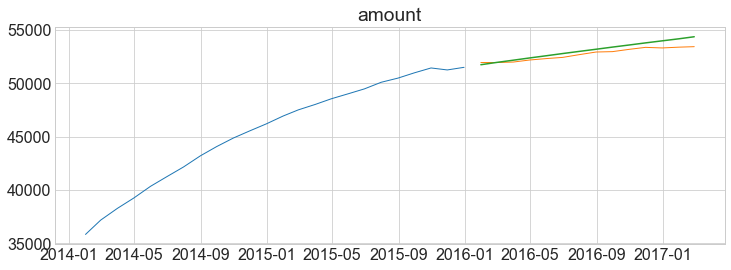

In [66]:
for col in train.columns:
    plot_and_eval(target_var = col)

Evaluate

In [67]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [68]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
8,holts_optimized,amount,456.0
0,last_observed_value,amount,1343.0
3,1_month_moving_avg,amount,1343.0
2,3 month_moving_avg,amount,1436.0
5,3_month_moving_avg,amount,1436.0
4,2_month_moving_avg,amount,1455.0
6,4_month_moving_avg,amount,1533.0
7,10_month_moving_avg,amount,2696.0
1,simple_average,amount,7181.0


Predict Based on Previous Cycle
Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day.

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence.

In the below example:

Compute the 365 average year over year differences from 2013 through 2015
Add that average delta to the values during 2015.
Set the index in your yhat dataframe to represent the dates those predictions are make for.
Let's get started....

Re-split data

In [69]:
df.index


DatetimeIndex(['2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31',
               '2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31',
               '2014-01-31', '2014-01-31',
               ...
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31'],
              dtype='datetime64[ns]', name='invoice_date', length=790458, freq=None)

In [70]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()


(431894, 4)
(186275, 4)
(172289, 4)


,customer_id,invoice_id,subscription_type,amount
invoice_date,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0
